In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from tqdm.auto import trange

# Functions for creating a dog

In [2]:
WALKING_TIME = 0
EATING_TIME = 0
PLAYING_TIME = 0

food_consumption_rate = 1.0 / (30 * 3600)
affection_consumption_rate = 1.0 / (50 * 3600)
walking_fat_converge_rate = 0.2
walking_affection_converge_rate = 0.4
playing_fat_converge_rate = 0.1
playing_affection_converge_rate = 0.20
eating_food_increase = 0.6
eating_fat_increase = 0.25

In [3]:
def apply_decreasing_rate(value: float, rate: float) -> float:
    """
    Apply a decreasing rate to a value
    :param value: current value
    :param rate: per second
    :return: updated value
    """
    return value - (60 * rate)

def converge(value: float, target: float, ratio: float) -> float:
    diff: float = (target - value) * ratio
    return transform_to_dec(value + diff)

def update_walking(dog_table_row):
    update_fat = converge(dog_table_row.iloc[0]['fat'], 0.0, walking_fat_converge_rate)
    update_affection = converge(dog_table_row.iloc[0]['affection'], 1.0, walking_affection_converge_rate)
    return (update_fat, update_affection)

def update_feeding(dog_table_row):
    update_food = min(dog_table_row.iloc[0]['food'] + eating_food_increase, 1.0)
    update_fat = min(dog_table_row.iloc[0]['fat'] + eating_fat_increase, 1.0)
    return (update_food, update_fat)

def update_playing(dog_table_row):
    update_fat = converge(dog_table_row.iloc[0]['fat'], 0.0, playing_fat_converge_rate)
    update_affection = converge(dog_table_row.iloc[0]['affection'], 1.0, playing_affection_converge_rate)
    return (update_fat, update_affection)

def update_food(dog_table_row):
    return transform_to_dec(max(
        0.0,
        apply_decreasing_rate(dog_table_row.iloc[0]['food'], food_consumption_rate)
    ))

def update_affection(dog_table_row):
    return transform_to_dec(max(
        0.0,
        apply_decreasing_rate(dog_table_row.iloc[0]['affection'], affection_consumption_rate)
    ))

def update_happiness(dog_table_row) -> float:  # between 0 and 1
    return min(
        dog_table_row.iloc[0]['food'],
        1.0 - dog_table_row.iloc[0]['fat'],
        dog_table_row.iloc[0]['affection']
    )

def update_alive(dog_table_row):
    return dog_table_row.iloc[0]['alive'] & (dog_table_row.iloc[0]['happiness'] > 0.0)

def new_state_after_1_minute(dog_table, action_taken='NO ACTION'):
    
    dog_table_row = dog_table.tail(1)
    new_state_dog_id = dog_table_row.iloc[0]['dog_id']
    
    new_state_food = update_food(dog_table_row)
    new_state_fat = dog_table_row.iloc[0]['fat']
    new_state_affection = update_affection(dog_table_row)
    
    new_state_last_action_taken = dog_table_row.iloc[0]['last_action_taken']
    new_state_can_action_be_taken = dog_table_row.iloc[0]['can_action_be_taken']
    new_state_minutes_since_last_action = dog_table_row.iloc[0]['minutes_since_last_action']
    
    new_state_minute = dog_table_row.iloc[0]['minute'] + 1
    new_state_minutes_since_last_action = dog_table_row.iloc[0]['minutes_since_last_action'] + 1
    
    new_state_happiness = update_happiness(dog_table_row)
    new_state_alive = update_alive(dog_table_row)
    
    if ((action_taken != 'NO ACTION') & (dog_table_row.iloc[0]['can_action_be_taken'])):
        new_state_last_action_taken = action_taken
        new_state_can_action_be_taken = False
        new_state_minutes_since_last_action = 0
    
    if ((dog_table_row.iloc[0]['last_action_taken'] == 'WALKING') &
        (dog_table_row.iloc[0]['minutes_since_last_action'] == WALKING_TIME)):
        new_state_fat, new_state_affection = update_walking(dog_table_row)
        new_state_last_action_taken = 'NO ACTION'
        new_state_can_action_be_taken = True
        new_state_minutes_since_last_action = 0        

    if ((dog_table_row.iloc[0]['last_action_taken'] == 'FEEDING') &
        (dog_table_row.iloc[0]['minutes_since_last_action'] == EATING_TIME)):
        new_state_food, new_state_fat = update_feeding(dog_table_row)
        new_state_last_action_taken = 'NO ACTION'
        new_state_can_action_be_taken = True
        new_state_minutes_since_last_action = 0

    if ((dog_table_row.iloc[0]['last_action_taken'] == 'PLAYING') &
        (dog_table_row.iloc[0]['minutes_since_last_action'] == PLAYING_TIME)):
        new_state_fat, new_state_affection = update_playing(dog_table_row)
        new_state_last_action_taken = 'NO ACTION'
        new_state_can_action_be_taken = True
        new_state_minutes_since_last_action = 0
        
    dog_table = dog_table.append({
        'dog_id': new_state_dog_id,
        'minute': new_state_minute,
        'happiness': new_state_happiness,
        'food': transform_to_dec(new_state_food),
        'fat': transform_to_dec(new_state_fat),
        'affection': transform_to_dec(new_state_affection),
        'alive': new_state_alive,
        'can_action_be_taken': new_state_can_action_be_taken, 
        'last_action_taken': new_state_last_action_taken,
        'minutes_since_last_action': new_state_minutes_since_last_action
        }, ignore_index=True)
    
    return dog_table

# Functions for RL

## Initialize dog

In [4]:
def init_dog_table(type_init='real'):

    dog_table = pd.DataFrame(columns=[
        'dog_id', 'minute',
        'happiness', 'food', 'fat', 'affection',
        'alive', 'can_action_be_taken', 'last_action_taken', 'minutes_since_last_action'
    ])

    if type_init == 'real':
        dog_table = dog_table.append({
            'dog_id': 1, 'minute': 0,
            'happiness': 0,
            'food': transform_to_dec(0.5), 
            'fat': transform_to_dec(0), 
            'affection': transform_to_dec(0.5),
            'alive': True, 'can_action_be_taken': True, 'last_action_taken': 'NO ACTION', 'minutes_since_last_action': 0
            }, ignore_index=True)

    if type_init == 'random':
        dog_table = dog_table.append({
            'dog_id': 1, 'minute': 0,
            'happiness': 0,
            'food': transform_to_dec(random.random()), 
            'fat': transform_to_dec(random.random()), 
            'affection': transform_to_dec(random.random()),
            'alive': True, 'can_action_be_taken': True, 'last_action_taken': 'NO ACTION', 'minutes_since_last_action': 0
            }, ignore_index=True)
    
    dog_table['happiness'] = update_happiness(dog_table)
    
    return dog_table

## Choose action

In [5]:
def choose_action(state, Q, action_space, epsilon):
    
    if np.random.uniform(0, 1) < epsilon:
        action = random.choices(range(len(action_space)), k = 1)[0]
    
    else:
        state_q = get_state_q(state,0)
        listy = Q[state_q, :]
        winner = np.argwhere(listy == np.amax(listy))
        winner_list = winner.flatten().tolist()
        action = random.choices(winner_list, k = 1)[0]
    
    return action

## Run an episode

In [6]:
def create_episode(Q, max_steps, epsilon):
    
    dog_table = init_dog_table()
    state = dog_table.tail(1)

    t = 0
    while ((state.iloc[0]['alive']) & (t < max_steps)):
        t += 1
        action = choose_action(
            state = state,
            Q = Q,
            action_space = action_space,
            epsilon = epsilon
        )
        dog_table = new_state_after_1_minute(dog_table, action_taken = action_space[action])
        state = dog_table.tail(1)

    return dog_table

## Make state for Q

In [7]:
def transform_to_dec(value, dec=100):
    return np.floor(dec*value)/dec

In [8]:
def get_state_q(current_state, t):
    return int('{:02d}{:02d}{:02d}'.format(
        min(99,int(current_state.iloc[t]['food']*100)),
        min(99,int(current_state.iloc[t]['fat']*100)),
        min(99,int(current_state.iloc[t]['affection']*100))
    ))

## State action reward

In [9]:
def state_action_reward(dog_table, t, action_space):
    
    state_t = get_state_q(dog_table, t)

    action_t_name = dog_table.iloc[t]['last_action_taken'] if (
        dog_table.iloc[t]['minutes_since_last_action'] == 0
    ) else 'NO ACTION'
    
    action_t = action_space.index(action_t_name)

    reward_t = dog_table.loc[dog_table['minute'] == t].iloc[0]['happiness']

    state_t_1 = get_state_q(dog_table, t + 1)
    
    return (state_t, action_t, reward_t, state_t_1)


## Update Q function

In [22]:
# Function to learn the Q-value
def update(Q, state_t, reward_t, action_t, state_t_1, gamma, alpha):
    
    #print('Q[state_t, action_t]')
    #print(Q[state_t, action_t])
    
    #print('alpha, gamma')
    #print(alpha, gamma)

    #print('reward_t')
    #print(reward_t)

    #print('max(Q[state_t_1,])')
    #print(max(Q[state_t_1,]))

    #print('reward_t + gamma * max(Q[state_t_1,]) - Q[state_t, action_t]')
    #print(reward_t + gamma * max(Q[state_t_1,]) - Q[state_t, action_t])

    #print('alpha * (reward_t + gamma * max(Q[state_t_1,]) - Q[state_t, action_t])')
    #print(alpha * (reward_t + gamma * max(Q[state_t_1,]) - Q[state_t, action_t]))

    #print('Q[state_t, action_t] + alpha * (reward_t + gamma * max(Q[state_t_1,]) - Q[state_t, action_t])')
    #print(Q[state_t, action_t] + alpha * (reward_t + gamma * max(Q[state_t_1,]) - Q[state_t, action_t]))

    Q[state_t, action_t] = Q[state_t, action_t] + alpha * (reward_t + gamma * max(Q[state_t_1,]) - Q[state_t, action_t])
    
    #print('New Q[state_t, action_t]')
    #print(Q[state_t, action_t])

    return Q

## Plots

In [11]:
def intermediate_plots(len_steps_plot, all_overall_reward_t):
    
    # Create some mock data
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('episodes')
    ax1.set_ylabel('nber steps', color=color)
    ax1.plot(range(len(len_steps_plot)), len_steps_plot, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('average reward', color=color)  # we already handled the x-label with ax1
    ax2.plot(range(len(all_overall_reward_t)), all_overall_reward_t, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

In [32]:
def display_analyse_Q(Q):
    
    analyse_Q = pd.DataFrame(columns=[
        'state_id', 'food_id', 'fat_id', 'affection_id',
        'no_action', 'walking', 'feeding', 'playing',
    ])

    for i in trange(Q.shape[0]):
        analyse_Q = analyse_Q.append({
            'state_id': int(i),
            'food_id': int(np.floor(i/10000)),
            'fat_id': int(np.floor(i/100 % 100)),
            'affection_id': int(np.floor(i % 100)),
            'no_action': Q[i,0],
            'walking': Q[i,1],
            'feeding': Q[i,2],
            'playing': Q[i,3]
            }, ignore_index=True)

    analyse_Q.groupby('food_id').agg({
        'no_action': 'mean',
        'walking': 'mean',
        'feeding': 'mean',
        'playing': 'mean'
    }).plot()

    analyse_Q.groupby('fat_id').agg({
        'no_action': 'mean',
        'walking': 'mean',
        'feeding': 'mean',
        'playing': 'mean'
    }).plot()

    analyse_Q.groupby('affection_id').agg({
        'no_action': 'mean',
        'walking': 'mean',
        'feeding': 'mean',
        'playing': 'mean'
    }).plot()

# This is where things are done

In [13]:
observation_space_n = 100*100*100
action_space = ['NO ACTION', 'WALKING', 'FEEDING', 'PLAYING']
action_space_n = len(action_space)

In [14]:
Q = np.full(
    shape=(observation_space_n, action_space_n),
    fill_value=3.25
)

## Get average reward

In [15]:
max_steps = 1000
avg_reward = []
for i in trange(100):
    dog_table = create_episode(Q = Q, max_steps = max_steps, epsilon = 1)
    for t in range(len(dog_table)-1):
        reward_t = dog_table.iloc[t]['happiness']
        avg_reward.append(reward_t)    

KeyboardInterrupt: 

In [ ]:
avg_reward_init = np.mean(avg_reward)
avg_reward_init

## Find Q(state,action) value function

In [34]:
max_steps = 1000000
epsilon_initial = 0.5
alpha_initial = 0.5
gamma = 1
convergence = False

In [17]:
Q = np.full(
    shape=(observation_space_n, action_space_n),
    fill_value=10.0#avg_reward_init
)

In [18]:
Q_previous = Q.copy()
(all_overall_reward, all_overall_reward_plot) = ([], [])
(all_overall_reward_t, all_overall_reward_t_plot) = ([], [])
(len_steps, len_steps_plot) = ([], [])
nber_steps = 0

In [35]:
# Starting with Q-learning

while not convergence:
    
    epsilon = epsilon_initial / np.ceil( (len(all_overall_reward)+1) / 10000)
    alpha = alpha_initial
    
    dog_table = create_episode(Q = Q, max_steps = max_steps, epsilon = epsilon)
    #print(dog_table)

    for t in range(len(dog_table)-1):
        (state_t, action_t, reward_t, state_t_1) = state_action_reward(dog_table, t, action_space)

        Q = update(Q, state_t, reward_t, action_t, state_t_1, gamma = 1, alpha = alpha)
    
    overall_reward = sum(dog_table['happiness'])
    
    all_overall_reward.append(overall_reward)
    all_overall_reward_t.append(overall_reward/len(dog_table))
    len_steps.append(len(dog_table)-1)
    nber_steps += len(dog_table)-1
    
    # print(episode, t, overall_reward, overall_reward/t)
    if len(all_overall_reward) % 100 == 0:
        
        all_overall_reward_plot.append(np.mean(all_overall_reward[-100:]))
        all_overall_reward_t_plot.append(np.mean(all_overall_reward_t[-100:]))
        len_steps_plot.append(np.mean(len_steps[-100:]))
        
        distance_q_matrices = np.linalg.norm(Q_previous - Q)
        convergence = distance_q_matrices < 0.00001
        Q_previous = Q.copy()
        
        print('Iter. {:7d} - Steps {:8d} - Eps. {:0.6f} - Alp. {:0.6f} - Dist. {:06.5f} - Total R. {:06.3f} - Avg R. {:0.3f}'.format(
            len(all_overall_reward),
            nber_steps,
            epsilon, alpha,
            distance_q_matrices,
            np.mean(all_overall_reward[-100:]),
            np.mean(all_overall_reward_t[-100:])
        ))
        #intermediate_plots(len_steps_plot, all_overall_reward_t_plot)
        
        dog_table_100 = create_episode(Q = Q, max_steps = 10000, epsilon = 0)
        
        dog_table_100.to_csv('dog_table/dog_table'+str(len(all_overall_reward))+'.csv', sep=',')
        print(len(dog_table_100))

    if len(all_overall_reward) % 100000000 == 0:
        display_analyse_Q(Q)


Iter.    3400 - Steps   262487 - Eps. 0.500000 - Alp. 0.500000 - Dist. 174.80587 - Total R. 35.256 - Avg R. 0.457
10001
Iter.    3500 - Steps   270508 - Eps. 0.500000 - Alp. 0.500000 - Dist. 183.44459 - Total R. 38.314 - Avg R. 0.462
10001
Iter.    3600 - Steps   279092 - Eps. 0.500000 - Alp. 0.500000 - Dist. 194.18114 - Total R. 41.916 - Avg R. 0.475
10001
Iter.    3700 - Steps   286428 - Eps. 0.500000 - Alp. 0.500000 - Dist. 179.16666 - Total R. 35.412 - Avg R. 0.467
10001
Iter.    3800 - Steps   295115 - Eps. 0.500000 - Alp. 0.500000 - Dist. 210.12677 - Total R. 41.949 - Avg R. 0.465
10001
Iter.    3900 - Steps   302727 - Eps. 0.500000 - Alp. 0.500000 - Dist. 195.94533 - Total R. 36.362 - Avg R. 0.459
10001
Iter.    4000 - Steps   310461 - Eps. 0.500000 - Alp. 0.500000 - Dist. 198.89980 - Total R. 37.514 - Avg R. 0.470
10001
Iter.    4100 - Steps   318274 - Eps. 0.500000 - Alp. 0.500000 - Dist. 201.28408 - Total R. 37.953 - Avg R. 0.468
10001
Iter.    4200 - Steps   325678 - Eps. 0.

29
Iter.   10300 - Steps   804715 - Eps. 0.250000 - Alp. 0.500000 - Dist. 829.08522 - Total R. 56.175 - Avg R. 0.453
10001
Iter.   10400 - Steps   816542 - Eps. 0.250000 - Alp. 0.500000 - Dist. 823.61803 - Total R. 54.950 - Avg R. 0.451
10001
Iter.   10500 - Steps   830100 - Eps. 0.250000 - Alp. 0.500000 - Dist. 982.91801 - Total R. 63.193 - Avg R. 0.454
10001
Iter.   10600 - Steps   842006 - Eps. 0.250000 - Alp. 0.500000 - Dist. 944.97807 - Total R. 54.297 - Avg R. 0.445
10001
Iter.   10700 - Steps   852178 - Eps. 0.250000 - Alp. 0.500000 - Dist. 811.17638 - Total R. 46.771 - Avg R. 0.444
10001
Iter.   10800 - Steps   862398 - Eps. 0.250000 - Alp. 0.500000 - Dist. 851.96379 - Total R. 46.681 - Avg R. 0.444
10001
Iter.   10900 - Steps   873427 - Eps. 0.250000 - Alp. 0.500000 - Dist. 861.43949 - Total R. 50.917 - Avg R. 0.447
10001
Iter.   11000 - Steps   885608 - Eps. 0.250000 - Alp. 0.500000 - Dist. 998.53180 - Total R. 55.552 - Avg R. 0.442
10001
Iter.   11100 - Steps   896965 - Eps.

KeyboardInterrupt: 

## Analysis

In [ ]:
dog_table_100 = create_episode(Q = Q, max_steps = 10000, epsilon = 0)
dog_table_100

In [ ]:
dog_table_100.to_csv('dog_table'+str(len(all_overall_reward))+'.csv', sep=',')
print(len(dog_table_100))


In [27]:
Q[490049,:]

array([22.1693298 , 21.95484588, 19.2094487 , 22.11607393])

In [ ]:
listy = Q[500051, :]
winner = np.argwhere(listy == np.amax(listy))
winner_list = winner.flatten().tolist()
action = random.choices(winner_list, k = 1)[0]
action

In [ ]:
action = np.argmax(Q[state_q, :])

In [38]:
for i in range(Q.shape[1]):
    print(Q[:,i])
    print(np.mean(Q[:,i]))

[10. 10. 10. ... 10. 10. 10.]
11.197822666367424
[10. 10. 10. ... 10. 10. 10.]
10.710290950799594
[10. 10. 10. ... 10. 10. 10.]
11.030782747531367
[10. 10. 10. ... 10. 10. 10.]
10.687791479142733


In [ ]:
dog_table = create_episode(
        Q = Q,
        max_steps = max_steps,
        epsilon = 0)
dog_table

In [ ]:
sum(dog_table['happiness'])

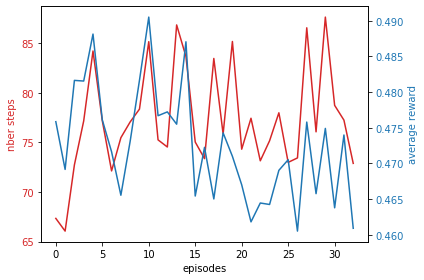

In [29]:
intermediate_plots(len_steps_plot, all_overall_reward_t_plot)

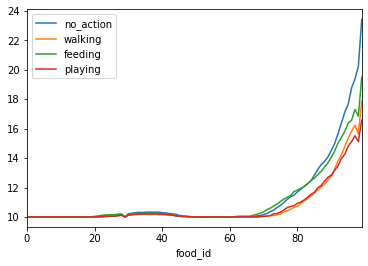

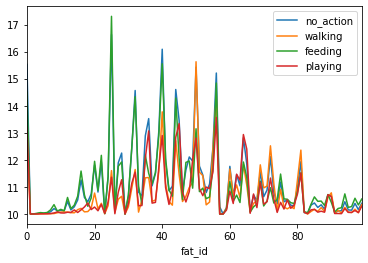

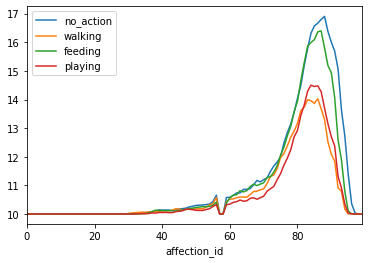

In [36]:
display_analyse_Q(Q)